# | HW3 | MobileNetV2 변형해 보기

**Due: 9/26, 11:59 PM**

- **채점 기준**
  - 아래 과제 설명을 따라야한다.
  - test accuracy가 **80% 이상** 나와야 한다.
- **제출**
  - "HW3_학번_이름.ipynb" 형태로 저장하여 Jupyter Notebook을 그대로 제출.
    - 예: HW3_2022_12345_keondo.ipynb
  - output 지우지 말아 주세요

---

`BatchNormalization(axis, momentum, epsilon)` : https://keras.io/api/layers/normalization_layers/batch_normalization/
- axis: Batch normalization이 적용될 axis. 우리는 채널에 대해서 BN을 적용할 것이다. 
- momentum: Moving average에 적용될 momentum 계수
- epsilon: 0으로 나누는 것을 방지하기 위한 작은 수.


`DepthwiseConv2D(kernel_size, strides, padding, use_bias, depthwise_regularizer)` : https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/

paper:[MobileNetV3](https://openaccess.thecvf.com/content_ICCV_2019/papers/Howard_Searching_for_MobileNetV3_ICCV_2019_paper.pdf)  

이번 과제에서는 MobileNetV3에서 추가된 내용 중 일부를 반영해 볼 것이다. MobilenetV3에서는 모델의 마지막 부분에 아래 그림과 같은 변화가 있었는데, 요약하자면
* Average pooling 앞의 1x1 Convolution layer와 Average pooling layer의 순서를 바꾸어 줌으로써 Computation은 줄이면서 정보의 손실은 최소화하였다.
* 위 변화가 일어나게 됨으로써 그 이전 Inverted residual layer에서 projection/filtering을 해 줄 필요가 없어졌다. 따라서 마지막 Inverted residual layer의 Expansion 이후 바로 Average pooling이 오게 된다.
* 아래 그림을 보면 더 이해가 쉬울 것이다.
<img src="https://user-images.githubusercontent.com/37704174/112775642-734f8a80-9078-11eb-9bc1-a860a1fea407.PNG" width="700" height="700"/> 
* 마지막 Inverted residual layer는 Original last stage 그림에서 맨 앞 세개이다.


<br>
위 내용을 참조하여 Network의 마지막 부분을 변형한 MobileNetV2plus를 구성하라. 위 그림상의 H-swish는 고려하지 않아도 된다.
<img src="https://user-images.githubusercontent.com/37704174/112777027-1229b600-907c-11eb-9f89-a7b61c0843be.PNG" width="700" height="700"/>  

- **채점기준**
  - 위의 변경 사항 반영하기
    - MobileNetV2에서 마지막 inverted residual block 및 뒷부분을 고치면 됨
    - Average pooling의 output의 가로 세로는 1임
  - test accuracy **80%** 이상
    - BatchNormalization, Activation, Dropout, Regularization, Weight initialization 등 자유롭게 수정, 추가, 제거 가능
    - `strides` 수정 가능
    - 나머지는 그대로


## Import Modules

In [1]:
import tensorflow as tf
### Q1. Import modules ###
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Activation, Flatten, Conv2D, \
    DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
#########################

## Inverted Residual Block

- 실습 때 한 것과 동일 

In [2]:
def _inverted_res_block(inputs, expansion, filters, strides):
    x = inputs
    in_chnls = inputs.shape[-1]
    # Expansion
    if expansion != 1:
        x = Conv2D(kernel_size=1, filters=in_chnls * expansion, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
        x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
        x = ReLU(max_value=6)(x)
        
    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False, depthwise_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)
    
    # Linear bottleneck
    x = Conv2D(kernel_size=1, filters=filters, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(4e-5))(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    # No activation
    
    # Residual connection
    if in_chnls == filters and strides == 1:
        x = Add()([inputs, x])
        
    return x #return output of layer

## MobileNetV2 변형 구현

In [3]:
def MobileNetV2plus(input_shape, classes):
    inputs = Input(shape=input_shape)
    
    ### Q2. Modify MobileNetV2 ###
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU(max_value=6)(x)

    # inverted_res_blocks
    x = _inverted_res_block(x, expansion=1, filters=16, strides=1)

    x = _inverted_res_block(x, expansion=6, filters=24, strides=1)
    x = _inverted_res_block(x, expansion=6, filters=24, strides=1)

    x = _inverted_res_block(x, expansion=6, filters=32, strides=1)
    x = _inverted_res_block(x, expansion=6, filters=32, strides=1)
    x = _inverted_res_block(x, expansion=6, filters=32, strides=1)

    x = _inverted_res_block(x, expansion=6, filters=64, strides=2)
    x = _inverted_res_block(x, expansion=6, filters=64, strides=1)
    x = _inverted_res_block(x, expansion=6, filters=64, strides=1)
    x = _inverted_res_block(x, expansion=6, filters=64, strides=1)

    x = _inverted_res_block(x, expansion=6, filters=96, strides=1)
    x = _inverted_res_block(x, expansion=6, filters=96, strides=1)
    x = _inverted_res_block(x, expansion=6, filters=96, strides=1)

    x = _inverted_res_block(x, expansion=6, filters=160, strides=2)
    x = _inverted_res_block(x, expansion=6, filters=160, strides=1)
    x = _inverted_res_block(x, expansion=6, filters=160, strides=1)

    # x = _inverted_res_block(x, expansion=6, filters=320, strides=1)
    # last stage
    x = Conv2D(kernel_size=1, filters=160*6, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization(momentum=0.999, epsilon=0.001)(x)
    x = ReLU(max_value=6)(x)

    # global average pooling  
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(1280, use_bias=False)(x)
    x = ReLU(max_value=6)(x)
    x = Dropout(0.2)(x)
    
    # FC layer
    outputs = Dense(classes, activation='softmax')(x)
    ##############################  1228800 
                                    
    return Model(inputs=inputs, outputs=outputs)


In [4]:
my_mobilenet = MobileNetV2plus((32, 32, 3), classes=10)

In [5]:
my_mobilenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

## Training Data

- keras dataset 혹은 tensorflow dataset 이용
- train data를 9:1로 나눠서 validation data로 이용

In [6]:
from tensorflow.keras.datasets import cifar10
#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Split train set into train/valid set
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train, test_size=0.1)

## Data Preprocessing
자유롭게 전처리

In [7]:
### Q3. Preporcessing ###
BATCH_SIZE = 128
# SHUFFLE_BUFFER_SIZE = 1000

# def normalizing(image, label):
#     image = tf.cast(image, tf.float32)  # cast to tf.float32
#     image = tf.image.per_image_standardization(image)
#     return image, label

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# train_loader = train_dataset.map(normalizing).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# valid_loader = valid_dataset.map(normalizing).batch(BATCH_SIZE)
# test_loader = test_dataset.map(normalizing).batch(BATCH_SIZE)
# x_test = np.concatenate([inputs for inputs, _ in test_loader], axis=0)
x_train = tf.image.per_image_standardization(x_train)
x_valid = tf.image.per_image_standardization(x_valid)
x_test = tf.image.per_image_standardization(x_test)
# x_train, x_valid, x_test = x_train / 255.0, x_valid / 255.0, x_test / 255.0
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
#########################

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 32, 32, 3)


## Model Compile
loss function, optimizer 설정

In [8]:
### Q4. Model compile ###
def scheduler(epoch, lr):
    if epoch < 150:
        return 0.1
    elif (epoch >= 150) and (epoch < 225):
        return 0.01     
    else:
        return 0.001

optimzier = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=4e-5)
my_mobilenet.compile(
    optimizer=optimzier,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
#########################

In [9]:
### Q5. Callbacks ###
callbacks = []
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir='./log_dir', histogram_freq=1))
callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/best_model', save_best_only=True, 
    save_weights_only=True, monitor='val_accuracy', mode='max'))
callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
#####################

## Model Training
hyperparameter를 적절히 설정한다. (epochs 등..)

In [10]:
### Q6. Training ###
EPOCHES = 50
# BATCH_SIZE = 128
# history = my_mobilenet.fit(
#     train_loader,
#     validation_data=valid_loader,
#     callbacks=callbacks, 
#     epochs=EPOCHES
# )
history = my_mobilenet.fit(
    x_train, y_train, batch_size=BATCH_SIZE, 
    epochs=EPOCHES,
    callbacks=callbacks,              
    validation_data=(x_valid, y_valid), 
    shuffle=True
)
####################

Epoch 1/50
352/352 [==============================] - 77s 208ms/step - loss: 1.7734 - accuracy: 0.4124 - val_loss: 2.6419 - val_accuracy: 0.1024 - lr: 0.1000
Epoch 2/50
352/352 [==============================] - 72s 204ms/step - loss: 1.3527 - accuracy: 0.5854 - val_loss: 2.8483 - val_accuracy: 0.1024 - lr: 0.1000
Epoch 3/50
352/352 [==============================] - 73s 206ms/step - loss: 1.1253 - accuracy: 0.6668 - val_loss: 3.6520 - val_accuracy: 0.1152 - lr: 0.1000
Epoch 4/50
352/352 [==============================] - 72s 204ms/step - loss: 0.9778 - accuracy: 0.7265 - val_loss: 3.2033 - val_accuracy: 0.1024 - lr: 0.1000
Epoch 5/50
352/352 [==============================] - 72s 206ms/step - loss: 0.8647 - accuracy: 0.7702 - val_loss: 2.9308 - val_accuracy: 0.1854 - lr: 0.1000
Epoch 6/50
352/352 [==============================] - 72s 206ms/step - loss: 0.7848 - accuracy: 0.7984 - val_loss: 2.6207 - val_accuracy: 0.2130 - lr: 0.1000
Epoch 7/50
352/352 [==============================] 

## 참고용
조교가 학습한 모델의 validation accuracy를 그래프로 나타내 보았다.

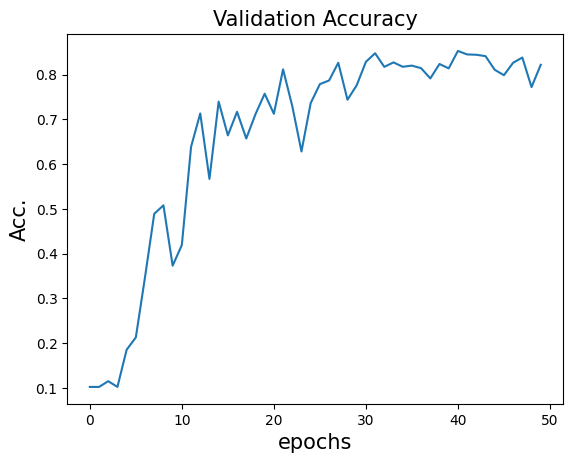

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

## Test Accuracy

test accuracy 측정 결과 **80% 이상**이 나와야 한다.

In [17]:
my_mobilenet = MobileNetV2plus((32, 32, 3), classes=10)
my_mobilenet.load_weights(filepath='./checkpoints/best_model')
my_mobilenet.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
my_mobilenet.evaluate(x_test,y_test)

313/313 [==============================] - 8s 21ms/step - loss: 0.8608 - accuracy: 0.8519


[0.8608081936836243, 0.8518999814987183]